# Solving a SOLA problem using the Problem class

The Problem class in the SOLA_DLI file contains all the tools for solving a SOLA problem within the "property bounds perspective". We start as usual by importing the needed packages

In [1]:
from core.main_classes.domains import HyperParalelipiped
from core.main_classes.spaces import PCb, DirectSumSpace, RN
from core.aux.normal_data import load_normal_data
from core.main_classes.functions import *
from core.main_classes.mappings import *
from core.main_classes.SOLA_DLI import Problem
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set global parameters for matplotlib
plt.rcParams.update({'font.size': 15})  # Set default font size
plt.rcParams['axes.linewidth'] = 1.5  # Set the thickness of the axes lines


In [2]:
# Create color Palette
colors = sns.color_palette('YlGnBu', n_colors=100)

Before even attempting to SOLVE a SOLA problem we must first define the mappings and spaces that we will work in. We will build these mathematical components one by one starting with the model space. 

The lines of codes in the "Edit regions" can be modified to explore variations of the given default SOLA problem.

In [3]:
####################
# Create model space
####################
# Edit region -------------
physical_parameters = ['m_1', 'm_2', 'm_3']

# Edit region -------------

physical_parameters_symbols = {'m_1': '$m_1$', 'm_2': '$m_2$', 'm_3': '$m_3$'}
no_of_params = len(physical_parameters)
domain = HyperParalelipiped(bounds=[[0, 1]], fineness=1000)
constituent_models_spaces = [PCb(domain=domain) for _ in physical_parameters]
# Create a dictionary with physical_parameters as keys
models_dict = {param: model_space for param, model_space in zip(physical_parameters, constituent_models_spaces)}
M = DirectSumSpace(tuple(constituent_models_spaces))

Then the data space. This is also where we iport the sensitivity kernels.

In [4]:
###################
# Create Data space
###################
# Edit region -------------
how_many_data = 100
# Edit region -------------

D = RN(dimension=how_many_data)

The the model-data mapping.

In [35]:
###########################
# Create model-data mapping 
###########################
# Make them into functions via interpolation
sensitivity_dict = {}
for i, param in enumerate(physical_parameters):
    sensitivity_dict[param] = []
    for index in range(how_many_data):
        if i in [0,1,2]:
            sensitivity_dict[param].append(NormalModes_1D(domain=domain, order=3, spread=0.05,
                                                        max_freq=10, seed=index + i*how_many_data))
        else:
            sensitivity_dict[param].append(NormalModes_1D(domain=domain, order=3, spread=0.05,
                                                        max_freq=10, seed=index + i*how_many_data, 
                                                        no_sensitivity_regions=[[0.5, 0.75]]))

constituent_mappings = [IntegralMapping(domain=models_dict[param], codomain=D, 
                                        kernels=sensitivity_dict[param]) for param in physical_parameters]
mappings_dict = {param: mapping for param, mapping in zip(physical_parameters, constituent_mappings)}
G = DirectSumMapping(domain=M, codomain=D, mappings=tuple(constituent_mappings))

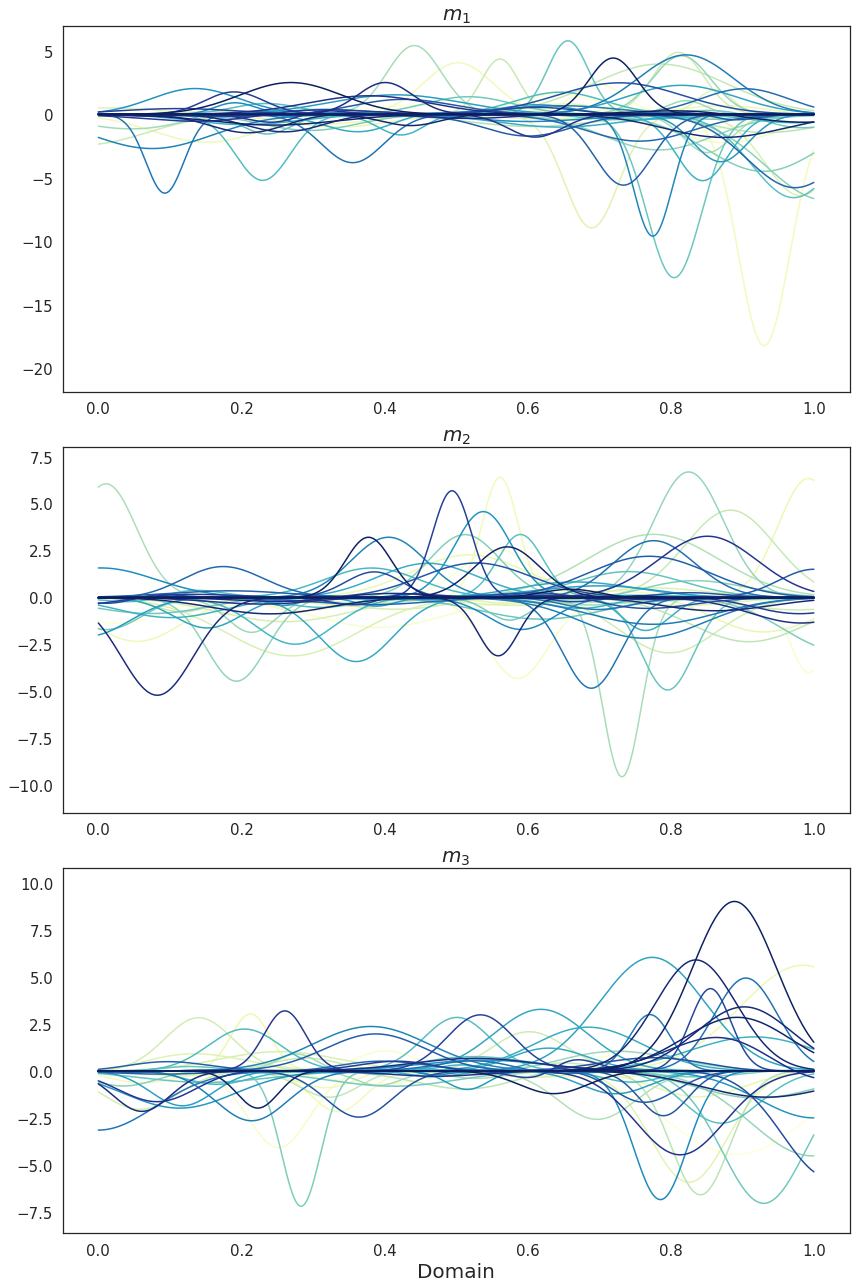

In [36]:
%matplotlib inline
fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12, 6*len(physical_parameters)))

for i, param in enumerate(physical_parameters):
    # Initialize y_min and y_max with extreme values to be updated dynamically
    y_min = float('inf')
    y_max = float('-inf')
    
    for j, kernel in enumerate(sensitivity_dict[param]):
        y_values = kernel.evaluate(domain.mesh)[1]  # Extract y-values from the kernel data
        
        # Update y_min and y_max based on current kernel's data
        y_min = min(y_min, np.min(y_values))
        y_max = max(y_max, np.max(y_values))
        
        axes[i].plot(domain.mesh, y_values, color=colors[int(100*j/how_many_data)])
    y_min *= 1.2
    y_max *= 1.2
    axes[i].set_title(physical_parameters_symbols[param], fontsize=20)
    axes[i].tick_params(axis='both', which='major', labelsize=15)
    axes[i].set_ylim([y_min, y_max])

# Adjust fontsize for ticks
axes[i].set_xlabel('Domain', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('Kernels_for_' + param + '.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [37]:
###################################
# Create property mapping and space
###################################
# Edit region -------------
target_types = {'m_1': Gaussian_1D,
                'm_2': Null_1D,
                'm_3': Null_1D}
width = 0.2 # same units as domain (km here)
how_many_targets = 100
enquiry_points = np.linspace(domain.bounds[0][0], 
                             domain.bounds[0][1], 
                             how_many_targets)
# Edit region -------------
P = RN(dimension=how_many_targets)
targets_dict = {}
for param, target_type in target_types.items():
    targets_dict[param] = []
    for i in range(how_many_targets):
        if target_type == Gaussian_1D: # MODIFY HERE THE SPECIAL TARGET AS WELL!!!!
            targets_dict[param].append(target_type(domain=domain,
                                                   center=enquiry_points[i],
                                                   width=width))
        else: 
            targets_dict[param].append(target_type(domain=domain))
constituent_mappings = [IntegralMapping(domain=models_dict[param], codomain=P, 
                                        kernels=targets_dict[param]) for param in physical_parameters]
T = DirectSumMapping(domain=M, codomain=P, mappings=tuple(constituent_mappings))

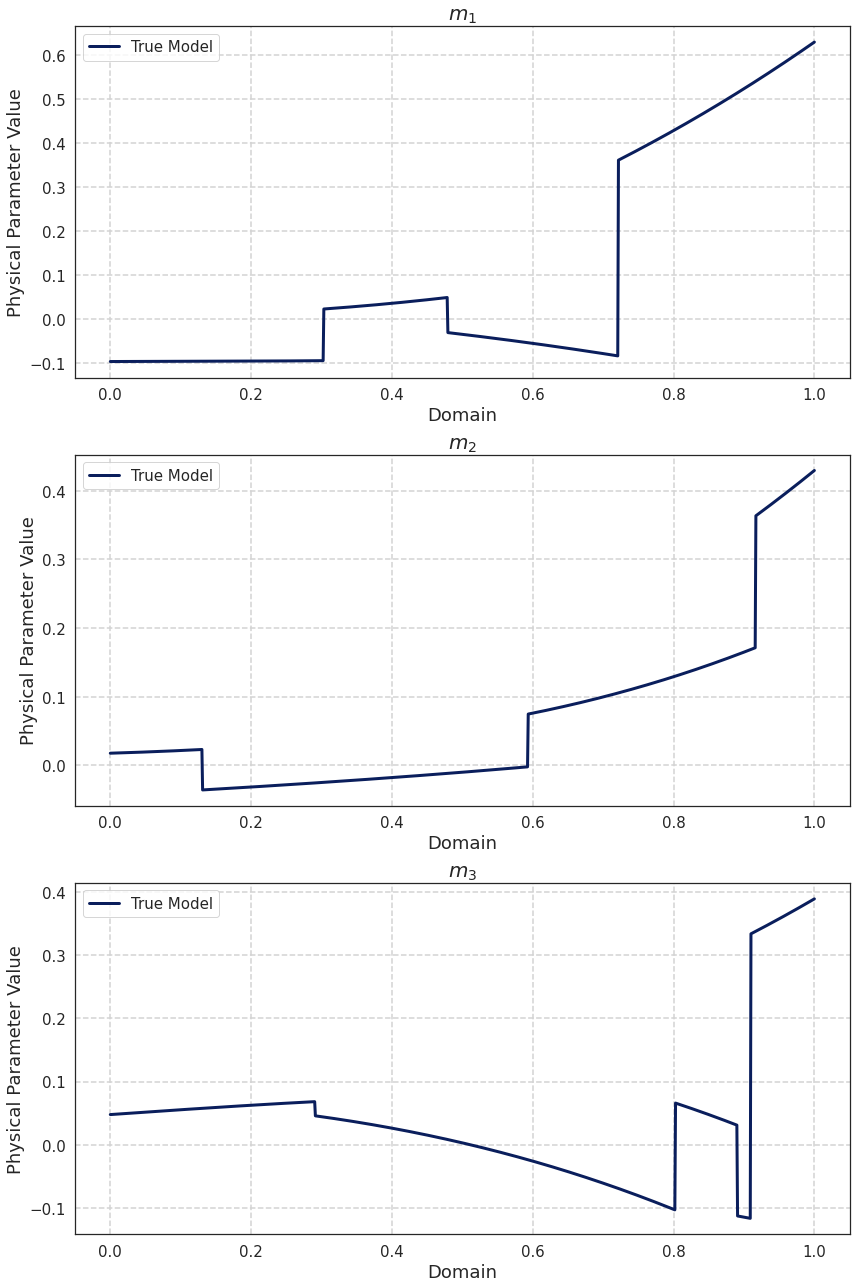

In [38]:
%matplotlib inline
#################################
# Create fake true model and data
#################################
true_model = M.random_member(args_list=[(4,), (3,), (13,)])
data = G.map(true_model)

fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12,6*len(physical_parameters)))
for i, (submodel, physical_parameter) in enumerate(zip(true_model, physical_parameters)):
    axes[i].plot(domain.mesh, submodel.evaluate(domain.mesh)[1], 
            label='True Model', color=colors[99], linewidth=3)
    axes[i].set_title(physical_parameters_symbols[physical_parameter], fontsize=20)
    axes[i].set_xlabel('Domain', fontsize=18)
    axes[i].set_ylabel('Physical Parameter Value', fontsize=18)
    axes[i].tick_params(axis='both', which='major', labelsize=15)
    axes[i].legend(fontsize=15)
    axes[i].grid(True, linestyle='--', linewidth=1.5, color='lightgray')  # Add gridlines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('truth.png', dpi=300, bbox_inches='tight')  # Save figure
plt.show()

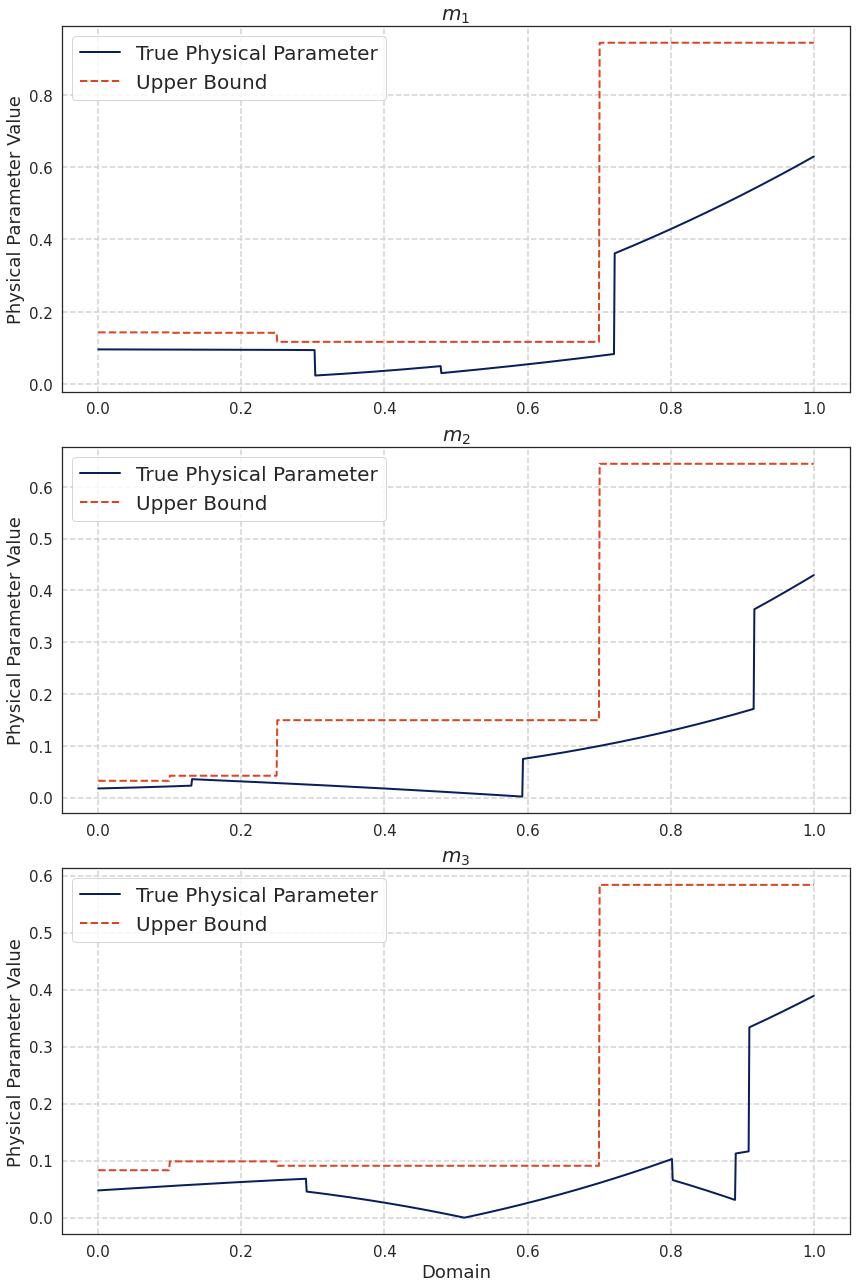

In [39]:
####################
# Compute norm bound
####################
# Edit region -------------
# Places where the true model will be evaluated
intervals = np.array([0,0.1, 0.25, 0.7, domain.bounds[0][1]])
# Edit region -------------
upper_bounds = []
for model in true_model:
    values = np.abs(model.evaluate(intervals[1:])[1])*1.5
    upper_bound = Piecewise_1D(domain=model.domain,
                               intervals=intervals,
                               values=values)
    upper_bounds.append(upper_bound)
norm_bound = M.norm(tuple(upper_bounds))

fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12,6*len(physical_parameters)))

for i, (upperbound, submodel, physical_parameter) in enumerate(zip(upper_bounds, true_model, physical_parameters)):
    axes[i].plot(domain.mesh, np.abs(submodel.evaluate(domain.mesh)[1]), 
             label='True Physical Parameter', color=colors[99], linewidth=2)
    axes[i].plot(domain.mesh, upperbound.evaluate(domain.mesh)[1], 
             label='Upper Bound', color='#dd4423', linestyle='--', linewidth=2)
    # Set title and labels
    axes[i].set_title(physical_parameters_symbols[physical_parameter], fontsize=20)
    axes[i].set_ylabel('Physical Parameter Value', fontsize=18)
    # Set tick parameters
    axes[i].tick_params(axis='both', which='major', labelsize=15)
    # Add legend
    axes[i].legend(fontsize=12)
    axes[i].grid(True, linestyle='--', linewidth=1.5, color='lightgray')  # Add gridlines
    axes[i].legend(fontsize=20)
plt.xlabel('Domain', fontsize=18)
plt.tight_layout()
plt.savefig('bound.pdf', bbox_inches='tight')
plt.show()

Now with all the components at hand, we put them all in a "Problem" class instance

In [40]:
problem = Problem(M=M, D=D, P=P, G=G, T=T, norm_bound=norm_bound, data=data)

In [41]:
problem.solve()

In [42]:
print(np.linalg.cond(problem.Lambda.matrix))

16763410537.366995


In [43]:
problem._compute_least_norm_property()

In [44]:
# Compute True property
true_property = T.map(true_model)

With the problem solved, we will find the solution (property bounds) in "problem.solution" and we can plot it.

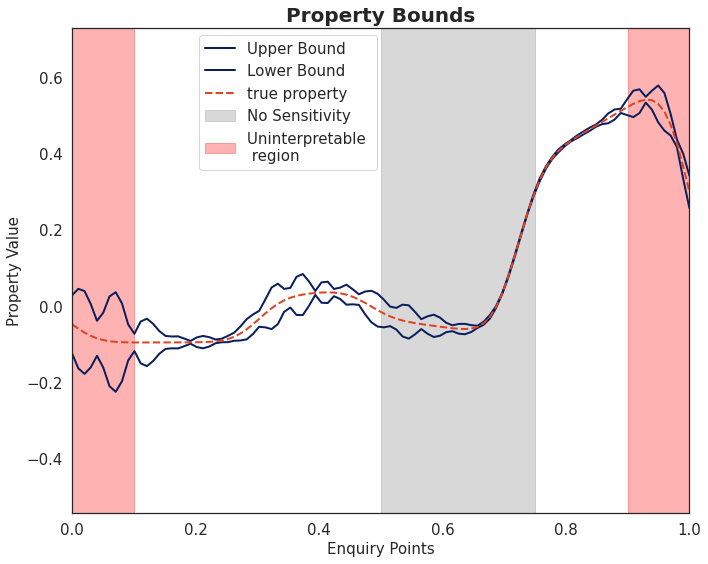

In [45]:
###############
# Plot solution
###############
# Find limits for y axis
y_max = np.mean(true_property) + (np.max(true_property) - np.min(true_property))
y_min = np.mean(true_property) - (np.max(true_property) - np.min(true_property))
# Plot the Solution section
plt.figure('Solution', figsize=(10, 8))
sns.set(style='white')  # Set seaborn style
plt.title('Property Bounds', fontsize=20, fontweight='bold')  # Increase font size and add bold
plt.plot(enquiry_points, problem.solution['upper bound'], color=colors[99], 
         linewidth=2, label='Upper Bound')  # Increase line width
plt.plot(enquiry_points, problem.solution['lower bound'], color=colors[99], 
         linewidth=2, label='Lower Bound')  # Increase line width and use dashed line
plt.plot(enquiry_points, true_property, color='#dd4423', linestyle='--', 
         linewidth=2, label='true property')
plt.fill_betweenx([y_min, y_max], 0.5, 0.75, color='gray', alpha=0.3, label='No Sensitivity')
plt.fill_betweenx([y_min, y_max], 0, width/2, color='red', alpha=0.3, label='Uninterpretable \n region')
plt.fill_betweenx([y_min, y_max], domain.bounds[0][1] - width/2, domain.bounds[0][1], color='red', alpha=0.3)
plt.xlim([domain.bounds[0][0], domain.bounds[0][1]])
plt.ylim([y_min, y_max])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='upper center', bbox_to_anchor=(0.35, 1))
plt.xlabel('Enquiry Points', fontsize=15)  # Add X-axis label with fontsize
plt.ylabel('Property Value', fontsize=15)  # Add Y-axis label with fontsize
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('new_solution.pdf', dpi=300, bbox_inches='tight')  # Increase resolution for high-quality output
plt.show()

In [46]:
problem._compute_resolving_kernels()

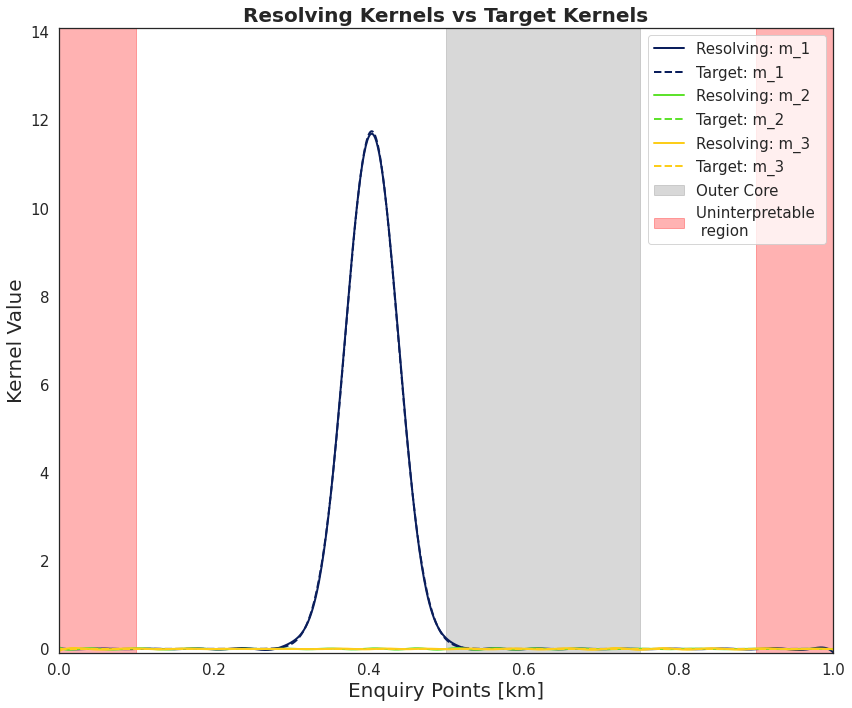

In [47]:
which_kernel = 40
param_color = dict(zip(physical_parameters, [colors[99], '#5ee22d', '#fccd1a']))
plt.figure(1, figsize=(12,10))

# Lists to store the y-values of all plotted data
all_y_values = []

for param, mapping in zip(physical_parameters, problem.A.mappings):
    # Plot resolving kernel
    resolving_kernel_y_values = mapping.kernels[which_kernel].evaluate(domain.mesh)[1]
    plt.plot(domain.mesh, resolving_kernel_y_values, 
             color=param_color[param], label='Resolving: ' + str(param), linewidth=2)
    all_y_values.extend(resolving_kernel_y_values)
    
    # Plot target kernel
    target_kernel_y_values = targets_dict[param][which_kernel].evaluate(domain.mesh)[1]
    plt.plot(domain.mesh, target_kernel_y_values, 
             linestyle='dashed', color=param_color[param], label='Target: ' + str(param), linewidth=2)
    all_y_values.extend(target_kernel_y_values)

# Calculate the minimum and maximum y-values from all the plotted data
y_min = min(all_y_values)*1.2
y_max = max(all_y_values)*1.2

# Fill between the specified y_min and y_max values
plt.fill_betweenx([y_min, y_max], 0.5, 0.75, color='gray', alpha=0.3, label='Outer Core')
plt.fill_betweenx([y_min, y_max], 0, width/2, color='red', alpha=0.3, label='Uninterpretable \n region')
plt.fill_betweenx([y_min, y_max], domain.bounds[0][1] - width/2, domain.bounds[0][1], color='red', alpha=0.3)
plt.xlim([domain.bounds[0][0], domain.bounds[0][1]])
plt.ylim([y_min, y_max])
plt.title('Resolving Kernels vs Target Kernels', fontsize=20, fontweight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.xlabel('Enquiry Points [km]', fontsize=20)
plt.ylabel('Kernel Value', fontsize=20)
plt.tight_layout()
plt.savefig('new_solution.png', dpi=300, bbox_inches='tight')
plt.savefig('resolving_kernel_' + str(which_kernel) + '.png', bbox_inches='tight', dpi=300)
plt.show()

In [48]:
problem._compute_least_norm_solution()

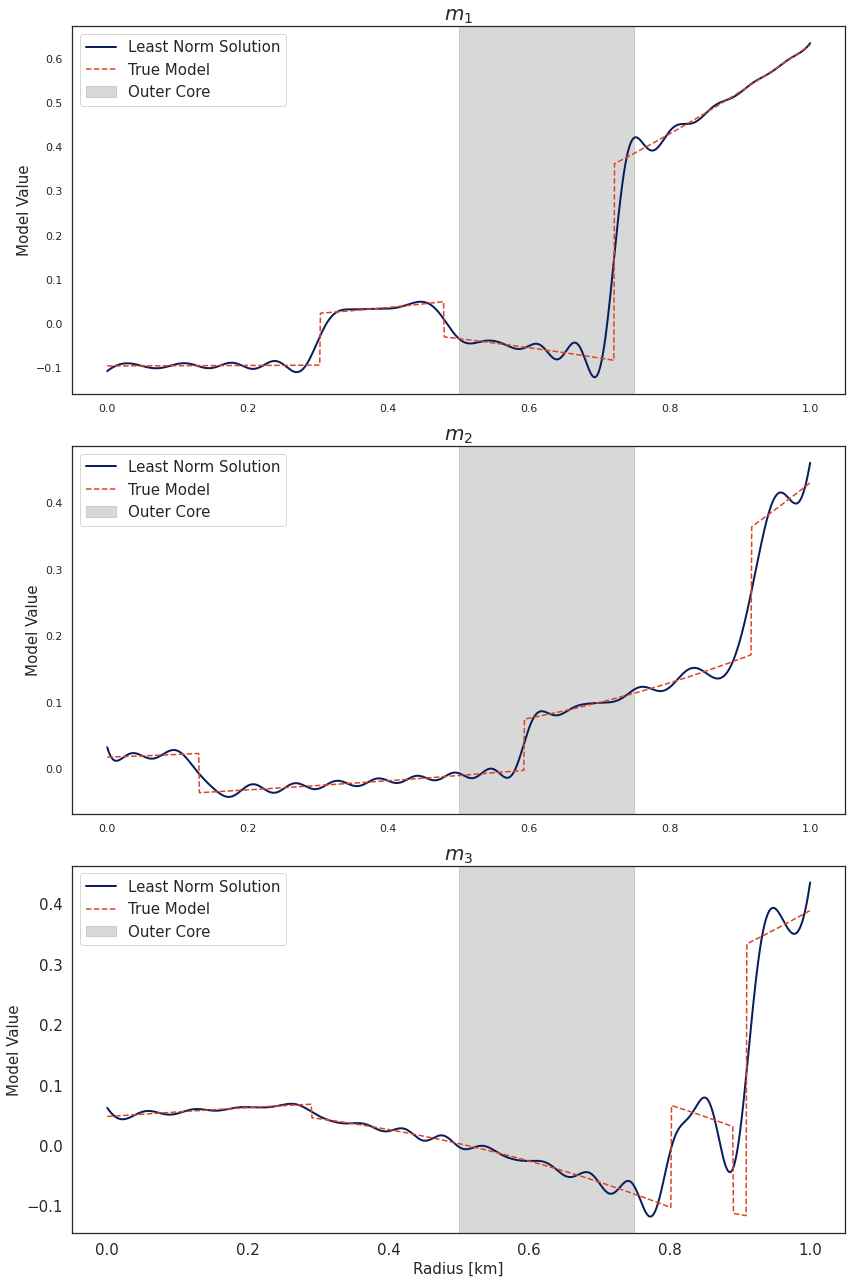

In [49]:
fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12, 6*len(physical_parameters)))
for i, physical_parameter in enumerate(physical_parameters):
    axes[i].set_title(physical_parameters_symbols[physical_parameter], fontsize=20)  # Increase font size and add bold
    axes[i].plot(domain.mesh, problem.least_norm_solution[i].evaluate(domain.mesh)[1], 
            color=colors[99], linewidth=2, label='Least Norm Solution')  # Increase line width
    axes[i].plot(domain.mesh, true_model[i].evaluate(domain.mesh)[1], 
                 color='#dd4423', linestyle='dashed', label='True Model')
    axes[i].set_ylabel('Model Value', fontsize=15)  # Add Y-axis label with fontsize
    y_min, y_max = axes[i].get_ylim()
    axes[i].fill_betweenx([y_min, y_max], 0.5, 0.75, color='gray', alpha=0.3, label='Outer Core')
    axes[i].set_ylim([y_min, y_max])
    axes[i].legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Radius [km]', fontsize=15)  # Add X-axis label with fontsize
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('new_solution.png', dpi=300, bbox_inches='tight')  # Increase resolution for high-quality output
plt.show()